<a href="https://colab.research.google.com/github/la26092002/API_Blog_express_Mongodb/blob/main/psoResnet12_05_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyswarms scikit-learn


In [ ]:
import pandas as pd
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


2025-05-12 17:16:49,733 - pyswarms.discrete.binary - INFO - Optimize for 20 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9, 'k': 10, 'p': 1}


Starting PSO optimization...


pyswarms.discrete.binary:   0%|          |0/20
Evaluating particles: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]
pyswarms.discrete.binary:   5%|▌         |1/20, best_cost=0.295
Evaluating particles: 100%|██████████| 20/20 [00:01<00:00, 13.94it/s]
pyswarms.discrete.binary:  10%|█         |2/20, best_cost=0.295
Evaluating particles: 100%|██████████| 20/20 [00:01<00:00, 13.91it/s]
pyswarms.discrete.binary:  15%|█▌        |3/20, best_cost=0.295
Evaluating particles: 100%|██████████| 20/20 [00:01<00:00, 14.32it/s]
pyswarms.discrete.binary:  20%|██        |4/20, best_cost=0.295
Evaluating particles: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]
pyswarms.discrete.binary:  25%|██▌       |5/20, best_cost=0.295
Evaluating particles: 100%|██████████| 20/20 [00:01<00:00, 14.88it/s]
pyswarms.discrete.binary:  30%|███       |6/20, best_cost=0.295
Evaluating particles: 100%|██████████| 20/20 [00:01<00:00, 13.91it/s]
pyswarms.discrete.binary:  35%|███▌      |7/20, best_cost=0.295
Evaluating part


Selected features: [  1   8   9  11  13  15  16  18  20  22  23  25  31  36  39  40  42  44
  45  46  48  50  55  56  57  58  59  60  67  69  70  72  73  74  75  77
  80  82  83  84  87  88  89  91  92  93  97  98  99 101 102 105 106 107
 109 112 113 114 121 123 128 130 132 133 135 140 144 145 148 150 151 152
 154 157 159 161 162 163 165 166 167 169 172 173 174 175 176 177 178 179
 181 184 186 188 189 190 191 193 195 197]
Number of selected features: 100

Final Accuracy: 0.7091


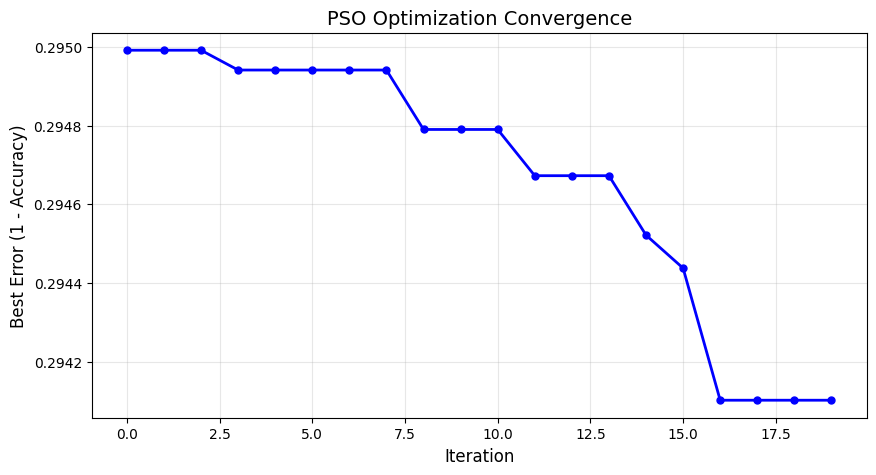

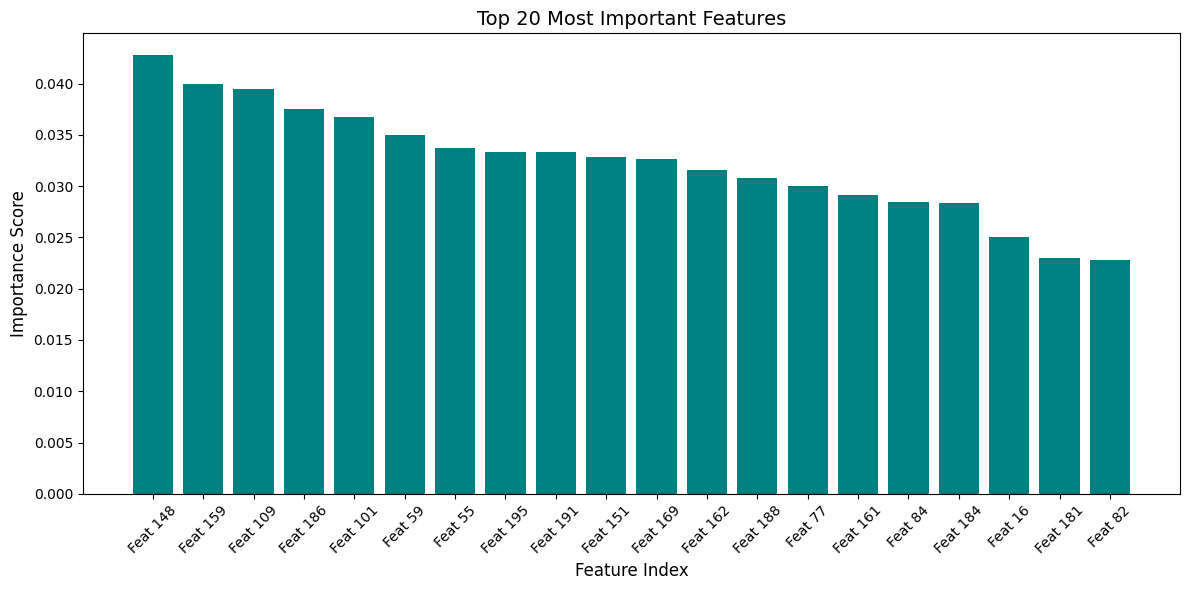

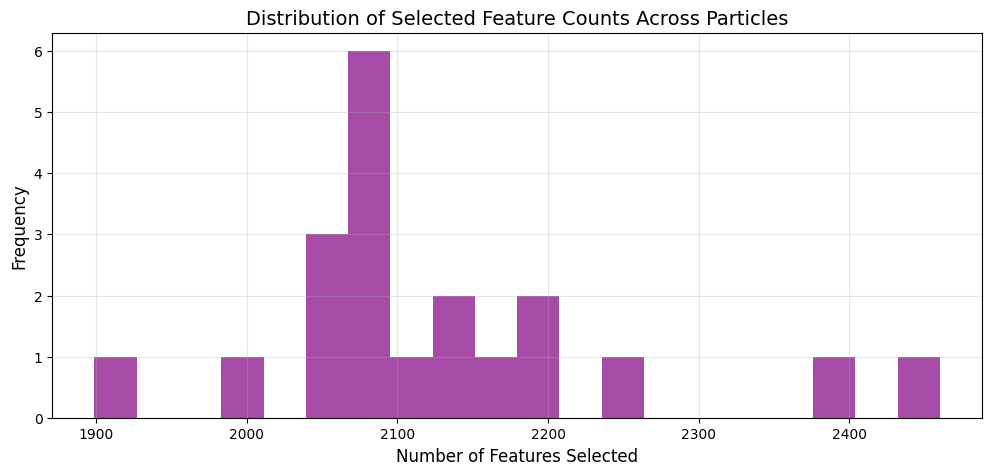

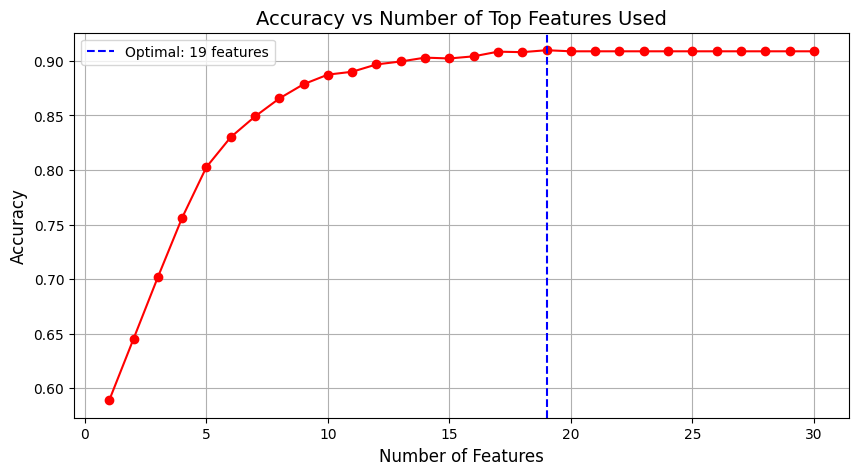

In [ ]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pyswarms as ps
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForest  # For feature importance

# Step 1: Load data
def load_data():
    features = pd.read_csv("/content/drive/MyDrive/FeaturesAllPartsLungTumor.csv",
                         dtype="float32",
                         usecols=lambda x: x != 'label').iloc[:, :200]
    labels = pd.read_csv("/content/drive/MyDrive/FeaturesAllPartsLungTumor.csv",
                       usecols=["label"])
    return features.values, labels.values.ravel()

X, y = load_data()
X_gpu = cp.asarray(X)
y_gpu = cp.asarray(y)

# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(X_gpu, y_gpu, test_size=0.3, random_state=42)

# Step 3: PSO objective function
def evaluate_particle(particle, X_train, X_test, y_train, y_test):
    mask = particle > 0.5
    if cp.sum(mask) == 0:
        return 1.0

    X_train_sel = X_train[:, mask]
    X_test_sel = X_test[:, mask]

    clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)
    clf.fit(cp.asnumpy(X_train_sel), cp.asnumpy(y_train))
    y_pred = clf.predict(cp.asnumpy(X_test_sel))
    acc = accuracy_score(cp.asnumpy(y_test), y_pred)
    return 1 - acc

def objective(particles):
    scores = Parallel(n_jobs=-1)(
        delayed(evaluate_particle)(particle, X_train, X_test, y_train, y_test)
        for particle in tqdm(particles, desc="Evaluating particles")
    )
    return np.array(scores)

# Step 4: Run PSO
n_features = X.shape[1]
options = {'c1': 2.0, 'c2': 2.0, 'w': 0.9, 'k': 10, 'p': 1}

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=n_features, options=options)
print("Starting PSO optimization...")
cost, pos = optimizer.optimize(objective, iters=20, verbose=True)

# Step 5: Get selected features
selected_features = pos > 0.5
selected_indices = np.where(selected_features)[0]
print("\nSelected features:", selected_indices)
print("Number of selected features:", len(selected_indices))

# Step 6: Final evaluation (using sklearn for feature importance)
X_train_sel = cp.asnumpy(X_train[:, selected_features])
X_test_sel = cp.asnumpy(X_test[:, selected_features])

final_clf = SklearnRandomForest(n_estimators=100, max_depth=10, random_state=42)
final_clf.fit(X_train_sel, cp.asnumpy(y_train))
y_pred = final_clf.predict(X_test_sel)
acc = accuracy_score(cp.asnumpy(y_test), y_pred)
print(f"\nFinal Accuracy: {acc:.4f}")

# ======================
# VISUALIZATIONS
# ======================

# 1. Convergence Plot
plt.figure(figsize=(10, 5))
plt.plot(optimizer.cost_history, 'b-o', linewidth=2, markersize=5)
plt.title('PSO Optimization Convergence', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Error (1 - Accuracy)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 2. Feature Importance (Top 20)
importances = final_clf.feature_importances_
top_n = min(20, len(importances))
sorted_idx = np.argsort(importances)[-top_n:][::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(top_n), importances[sorted_idx], color='teal')
plt.xticks(range(top_n), [f"Feat {selected_indices[i]}" for i in sorted_idx], rotation=45)
plt.title('Top 20 Most Important Features', fontsize=14)
plt.xlabel('Feature Index', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Feature Selection Distribution
plt.figure(figsize=(12, 5))
plt.hist([len(np.where(p > 0.5)[0]) for p in optimizer.pos_history],
         bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Selected Feature Counts Across Particles', fontsize=14)
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Accuracy vs Feature Count (Elbow Plot)
accuracies = []
for k in range(1, min(30, len(selected_indices)) + 1):
    top_k = sorted_idx[:k]
    clf = SklearnRandomForest(n_estimators=50, random_state=42)
    clf.fit(X_train_sel[:, top_k], cp.asnumpy(y_train))
    acc = accuracy_score(cp.asnumpy(y_test), clf.predict(X_test_sel[:, top_k]))
    accuracies.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies)+1), accuracies, 'r-o')
plt.title('Accuracy vs Number of Top Features Used', fontsize=14)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.axvline(x=np.argmax(accuracies)+1, color='b', linestyle='--',
           label=f'Optimal: {np.argmax(accuracies)+1} features')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

# Convert full GPU dataset to CPU for comparison
X_cpu = cp.asnumpy(X)
y_cpu = cp.asnumpy(y)

# Model on all features
clf_all = SklearnRandomForest(n_estimators=100, random_state=42)
scores_all = cross_val_score(clf_all, X_cpu, y_cpu, cv=5, scoring='accuracy')
print(f"\nAccuracy with all features (mean ± std): {scores_all.mean():.4f} ± {scores_all.std():.4f}")

# Model on selected features
X_sel_cpu = X_cpu[:, selected_indices]
clf_sel = SklearnRandomForest(n_estimators=100, random_state=42)
scores_sel = cross_val_score(clf_sel, X_sel_cpu, y_cpu, cv=5, scoring='accuracy')
print(f"Accuracy with PSO-selected features (mean ± std): {scores_sel.mean():.4f} ± {scores_sel.std():.4f}")



Accuracy with all features (mean ± std): 0.6876 ± 0.0043
Accuracy with PSO-selected features (mean ± std): 0.6850 ± 0.0040


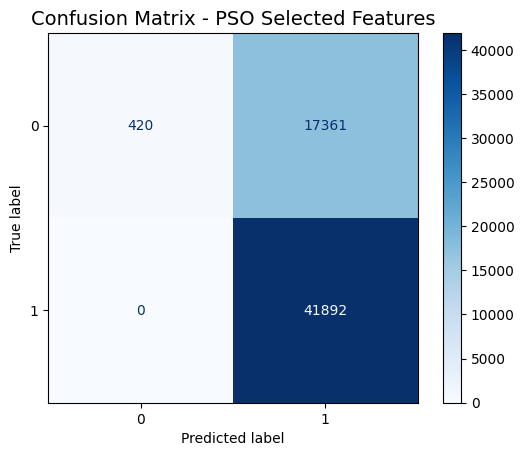

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
y_true = cp.asnumpy(y_test)
y_pred = final_clf.predict(X_test_sel)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - PSO Selected Features", fontsize=14)
plt.show()


----------------------